In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

In [15]:
class Unet_3_blocks(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(4, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)
        )


    def forward(self, x):

        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        xmiddle = self.middleU(x3)

        xup0_1 = torch.cat((x3,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x2,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x1,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        return xup3


In [16]:
class TrainDataset():
    def __init__(self, path):

        eddies_train = xr.open_dataset(path + 'eddies_train.nc')
        X_train = xr.open_dataset(path + 'OSSE_U_V_SLA_SST_train.nc')
        
        y = eddies_train.eddies.values
        
        X_verti = X_train.vomecrtyT.values
        X_hori = X_train.vozocrtxT.values
        X_SSH = X_train.sossheig.values
        X_SST = X_train.votemper.values
        
        ##Transformation
        X = np.array([X_verti, X_hori, X_SSH, X_SST])
        X = X.transpose((1,0,2,3))
        
        y = np.nan_to_num(y, nan=3)
            
        #Enregistre les index correspondant aux bords
        edges_index = []
        for i in range(1,X.shape[2]-1):
            for j in range (1,X.shape[3]-1):
                if np.isnan(X[32, 3, i, j]):
                    if np.any(np.isnan(X[32, 3, i-1:i+2, j-1:j+2])!=True):
                        edges_index.append((i, j))  
        
        
        for img_index in tqdm(range(X.shape[0])):
            for index in edges_index:
                i, j = index
                X[img_index, :, i, j] = np.mean(X[img_index, :, i-1:i+2, j-1:j+2], axis=(1,2))

        
        X = np.nan_to_num(X, nan=0)
    
        ##Normalisation
        
        X = (X - np.min(X, axis=(0,2,3), keepdims=True))/( np.max(X, axis=(0,2,3), keepdims=True) - np.min(X, axis=(0,2,3), keepdims=True) )
        
        ##Augmentation 
        
        X = torch.tensor(X)
        y = torch.tensor(y, dtype=torch.long).reshape(y.shape[0],1, y.shape[1],y.shape[2])
        data = torch.cat((X,y),dim=1)
        
        self.X_train = X
        self.y_train = y.reshape(y.shape[0], y.shape[2], y.shape[3])
        
        
    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

In [17]:
model = torch.load('models/UNet_3_blocks_V1.pth', map_location=torch.device('cpu'))
path = 'ocean-eddy-detection/' # local
test_dataset = TrainDataset(path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 284/284 [00:17<00:00, 15.84it/s]


In [40]:
def plotResults(model, dataSet, numberOfPlots):
    fig, ax = plt.subplots(numberOfPlots, 2, figsize=(10, 15))
    for i in range(numberOfPlots):
        X, y = next(iter(dataSet))
        ax[i, 0].imshow(y[0])
        ax[i, 0].set_title('Ground Truth')

        mask = y[0]==3
        y_pred = model(X)
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred[:, mask] = 3
        ax[i, 1].imshow(y_pred[0])
    plt.show()
    fig.tight_layout()

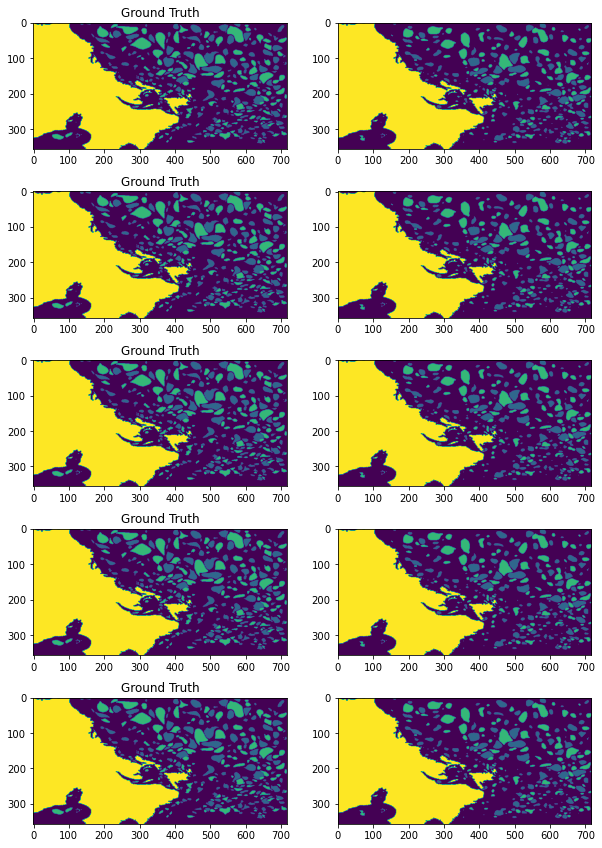

In [41]:
plotResults(model, test_loader, 5)